# Import required libaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import FormatStrFormatter, MaxNLocator, ScalarFormatter, FuncFormatter
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import pickle
import string
import csv
import os

# Useful functions

---
These are functions for the figures

In [2]:
def set_rc_params(dictArg:dict ={}):
    matplotlib.rcParams['xtick.major.pad'] = 1
    matplotlib.rcParams['ytick.major.pad'] = 1
    matplotlib.rcParams['axes.labelpad']   = 2
    matplotlib.rcParams['axes.titlepad']   = 3
    matplotlib.rcParams['axes.titlesize']   = 'medium'
    matplotlib.rcParams['axes.labelsize']   = 'small'
    matplotlib.rcParams['xtick.labelsize']   = 'x-small'
    matplotlib.rcParams['ytick.labelsize']   = 'x-small'
    
    for key,val in dictArg.items():
        matplotlib.rcParams[key] = val


In [3]:
def add_legend_trajectory(ax,cmap,ratio):
    
    markers = []
    
    for i in range(ratio.shape[0]):
        marker = matplotlib.lines.Line2D([0], [0],c=cmap(2*i),label=r'$\alpha=$' + str(ratio[i]))
        markers.append(marker)
    
    
    leg=ax.legend(handles=markers,loc=(0,1), ncol=6, fontsize='xx-small', framealpha=0,mode='expand')
    
    return leg

In [4]:
def add_panel_caption(axes: tuple, offsetX: tuple, offsetY: tuple, **kwargs):
    """
    This function adds letter captions (a,b,c,d) to Axes in axes
    at top left, with the specified offset, in RELATIVE figure coordinates
    """
    assert len(axes)==len(offsetX)==len(offsetY), 'Bad input!'
    
    fig=axes[0].get_figure()
    fbox=fig.bbox
    for ax,dx,dy,s in zip(axes,offsetX,offsetY,string.ascii_uppercase):
        axbox=ax.get_window_extent()
    
        ax.text(x=(axbox.x0/fbox.xmax)-abs(dx), y=(axbox.y1/fbox.ymax)+abs(dy),
                s=s,fontweight='extra bold', fontsize=10, ha='left', va='center',
               transform=fig.transFigure,**kwargs)

In [5]:
def SciNote(string):
    """
    Format numbers with Real scientific notation
    Ex: 'p-val={}'.format(SciNote(p))
    """
    f = ScalarFormatter(useOffset=False, useMathText=True)
    g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.2e' % x))
    fmt = FuncFormatter(g)
    return fmt(string)

---
These are funcions to compute the cumulative total cost

In [6]:
def penalty(x,k,mu,amp):
    '''This function generates a Heaviside step function of steepness k, centered around mu and of amplitude amp'''
    return(amp/(1+np.exp(2*k*(x-mu))))


def compute_cost_trajectories(trajectory, speed, force, a, b, cost_type, 
                              vtapis, Ltread, xb, 
                              kxpenalty, ampxpenalty):
    
    n_trajectoires = trajectory.shape[1]
    inst_cost = np.zeros(trajectory.shape)
    
    if cost_type == 'speed_quadratic':
        for i_t in range(n_trajectoires):
            inst_cost[:,i_t] = a*(speed[i_t]-vtapis)**2 + b*(trajectory[i_t] - Ltread)**2
    
    elif cost_type == 'force_quadratic':   
        for i_t in range(n_trajectoires):
            inst_cost[:,i_t] = a*(force[i_t]-vtapis)**2 + b*(trajectory[i_t] - Ltread)**2
        
    elif cost_type == 'speed_heaviside':
        for i_t in range(n_trajectoires):
            inst_cost[:,i_t] = a*(speed[:,i_t]-vtapis)**2 
            + b*penalty(x=trajectory[:,i_t], k=kxpenalty, mu=xb, amp=ampxpenalty)       
    
    elif cost_type == 'force_heaviside':   
        for i_t in range(n_trajectoires):
            inst_cost[:,i_t] = a*(force[:,i_t]-vtapis)**2 
            + b*penalty(x=trajectory[i_t], k=kxpenalty, mu=xb, amp=ampxpenalty)
    return inst_cost

# Main Figure

### Load and preprocess data

---
 Load simulation results, data and fit results

In [7]:
# Panel A and B
simulations_results_folder = 'PickleResults/Simulations'
diffuse_heaviside_effort_file = simulations_results_folder + '/DiffuseHeavisideSpatialCostEffort.pickle'
file_to_open = diffuse_heaviside_effort_file
with open(file_to_open, 'rb') as handle:
    results_simulations = pickle.load(handle)  
    
xk_vect_speed_heav = results_simulations['xk_vect_speed_heav']
tk = results_simulations['tk_vect_speed_heav'][:,0]
xdotk_vect_speed_heav = results_simulations['xdotk_vect_speed_heav']
acck_vect_speed_heav = results_simulations['acck_vect_speed_heav']

# Panel C and D
data_folder = './Data_for_fit/Before/'
file_to_open = data_folder + 'clean_max_pos_traj.pickle'
with open(file_to_open, 'rb') as handle:
    trajectories_before = pickle.load(handle)    
    
data_folder = './Data_for_fit/Final/'
file_to_open = data_folder + 'clean_max_pos_traj.pickle'
with open(file_to_open, 'rb') as handle:
    trajectories_final = pickle.load(handle)
file_to_open = data_folder + '_lesion_size_.p'   
with open(file_to_open, 'rb') as handle:
    lesion_size_final = pickle.load(handle)    

fit_results_folder = './PickleResults/Fit/'
# Before Lesion: effort parameter fitted trajectory
with open(fit_results_folder + 'a_fit_bounded_beforeXX.pickle', 'rb') as handle:
    results_a_bounded_before = pickle.load(handle) 
with open(fit_results_folder + 'xk_fit_bounded_beforeXX.pickle', 'rb') as handle:
    results_xk_bounded_before = pickle.load(handle)     
# After Lesion: effort parameter fitted trajectory
with open(fit_results_folder + 'a_fit_bounded_finalXX.pickle', 'rb') as handle:
    results_a_bounded_final = pickle.load(handle) 
with open(fit_results_folder + 'xk_fit_bounded_finalXX.pickle', 'rb') as handle:
    results_xk_bounded_final = pickle.load(handle)  
with open(fit_results_folder + 'delta_a_boundedXX.pickle', 'rb') as handle:
    delta_a_median_bounded_dict = pickle.load(handle)         

--- 
Compute the cumulative cost for panel B, right

In [8]:
a = 10
b = 1
kxpenalty = 1 
vtapis = 0.1
Ltread = 0.9
xb = 0.1
kxpenalty = 1
ampxpenalty = 10
aux_a = [.1,1,2,5,10,100] 
NTRAJECTORIES = len(aux_a) # I get rid of the alpha=100

inst_cost_speed_heav=compute_cost_trajectories(trajectory=xk_vect_speed_heav[:,0:NTRAJECTORIES-1], 
                          speed=xdotk_vect_speed_heav[:,0:NTRAJECTORIES-1], 
                          force=acck_vect_speed_heav[:,0:NTRAJECTORIES-1], 
                          a=a, b=b, cost_type='speed_heaviside', 
                          vtapis=vtapis, Ltread=Ltread, xb=xb,
                          kxpenalty=kxpenalty, ampxpenalty=ampxpenalty)

cumulative_cost_speed_heav = np.cumsum(inst_cost_speed_heav, axis=0)

---
Select data and fit results for panel C

In [9]:
example_rat = 'Rat302'
session_before = -1
session_final = 1
shift_time = 1
dt = 0.04

a_opt_er_before = results_a_bounded_before[example_rat][session_before]
xk_opt_er_before = results_xk_bounded_before[example_rat][session_before]
a_opt_er_final = results_a_bounded_final[example_rat][session_final]
xk_opt_er_final = results_xk_bounded_final[example_rat][session_final]

trajectory_er_before = trajectories_before[example_rat][session_before][int(shift_time/dt):]*0.01
trajectory_er_final = trajectories_final[example_rat][session_final][int(shift_time/dt):]*0.01

---
Animal list and lesion type for panel D

In [10]:
data_folder = './Data_for_fit/'
file_to_open = data_folder + 'AnimalList.txt'

selected_rats = []   
crimefile = open(file_to_open, 'r')
reader = csv.reader(crimefile)
rats_list = [row for row in reader]
for i_rat, aux in enumerate(rats_list):
    selected_rats.append(rats_list[i_rat][0][:])

selected_rats_lesion_size = []
for rat in lesion_size_final.keys():
    if not(np.isnan(lesion_size_final[rat][0])):
        selected_rats_lesion_size.append(rat)

selected_rats_lesion_size = list(set(selected_rats_lesion_size).intersection(selected_rats))

In [11]:
file_to_open = data_folder + 'LesionType.txt'
with open(file_to_open, 'r') as document:
    lestion_type_dict = {}
    for line in document:
        line = line.split()
        if not line:  # empty line?
            continue
        lestion_type_dict[line[0]] = line[1]    
        
CtrlColor='k'
DLSColor='xkcd:orange'
DMSColor='purple'
DSColor='xkcd:green'

ColorCode={'DS':DSColor,
           'DMS':DMSColor,
           'DLS':DLSColor,
           'Control':CtrlColor
          }

### Create the folder for the results 

In [12]:
figures_folder = 'FiguresLesionPaper/'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

### Plot the main figure

In [13]:
##################################################################################################
plt.close('all')
set_rc_params({'axes.labelsize':'x-small'})

nrows = 1
ncols = 4

figsize=(4.97,2.2)
linewidth = 1.5
fig=plt.figure(figsize=figsize,dpi=600)
fig.set_facecolor(None)

axes = []
##################################################################################################
# PANEL A   
gs = fig.add_gridspec(nrows=1, ncols=1, left=0, bottom=0.7, right=.149, top=1.,wspace=0.15,hspace=0.3)
ax=fig.add_subplot(gs[0])
axes.append(ax)

cmap = matplotlib.cm.get_cmap('jet', 2*NTRAJECTORIES)
for it in range(NTRAJECTORIES):
    ax.plot(tk,xk_vect_speed_heav[:,it],linewidth=linewidth,alpha=1.0,c=cmap(2*it))
ax.text(0.3,.78,'Spatial cost $=$ Diffuse \nEffort' + r'$\approx$' + 'Kinetic energy',fontsize=4)
#################################################
# COLORMAP
gsc = fig.add_gridspec(nrows=1,ncols=1,left=.172,bottom=0.7,top=1,right=.244)

axc = fig.add_subplot(gsc[0])
axc.xaxis.set_visible(False)
axc.spines['left'].set_visible(False)
axc.spines['bottom'].set_visible(False)
axc.spines['top'].set_visible(False)
axc.spines['right'].set_visible(False)
axc.tick_params(color=(0, 0, 0, 0),labelcolor=(0, 0, 0, 0),zorder=-10)

c = np.arange(1, 50*NTRAJECTORIES + 1)
cmap_ = matplotlib.cm.get_cmap('jet', 50*NTRAJECTORIES)
dummie_cax = axc.scatter(c, c, c=c, cmap=cmap_)
# Clear axis
axc.cla()

cbaxes = inset_axes(axc, width="20%", height="60%",loc=3) 
shift = 50
cb=fig.colorbar(dummie_cax,cax=cbaxes,ticks=[1+shift,50*NTRAJECTORIES],aspect=10)
cb.outline.set_edgecolor(None)
cb.set_label('Effort\nSensitivity', labelpad=-13,y=1.5, rotation=0,fontsize='xx-small')

cb.ax.set_yticklabels(['Low', 'High'],rotation=45,fontsize=4)
cb.ax.yaxis.set_tick_params(size=0)
#################################################
for ind_ax,ax in enumerate(axes):
    
    ax.plot(tk,xk_vect_speed_heav[0,0]+[0.1*t for t in tk],'--',color='Black',alpha=.8,zorder=-1,linewidth=1)
    ax.plot(tk,[0.1 for t in tk],':',color='Gray',zorder=-1,linewidth=1)
    
    if ind_ax==0:
        ax.set_ylabel('Position (cm)')    
        ax.set_yticklabels(['0'] + ['' for i in range(8)] + ['90'])
        ax.set_xlabel('Time (s)',labelpad=-2)
    else:
        ax.set_yticks([0.1*i for i in range(10)])
        ax.set_yticklabels(['' for i in range(10)])
    
    ax.set_yticks([0.1*i for i in range(10)])
    ax.set_xticks([i for i in range(8)])
    ax.set_xticklabels(['0'] + ['' for i in range(6)] + ['7'])
     

    ax.set_xlim(0,7.5)
    ax.set_ylim(0,0.9)
    ax.spines['bottom'].set_bounds(0,7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

##################################################################################################    
# PANEL B
gs = fig.add_gridspec(nrows=1, ncols=3, left=.325, bottom=0.7, right=0.905, top=1.,wspace=0.45,hspace=0.3)
cmap = matplotlib.cm.get_cmap('gray', 3*(NTRAJECTORIES-1))
#################################################
# Left
ax=fig.add_subplot(gs[0])
axes.append(ax)

for it in range(NTRAJECTORIES-1):
    ax.plot(tk,xk_vect_speed_heav[:,it],
            linewidth=linewidth,alpha=1.0,c=cmap(int(2.5*it)))

ax.plot(tk,xk_vect_speed_heav[0,0]+[0.1*t for t in tk],'--',color='Black',alpha=.8,zorder=-1,linewidth=1)
ax.plot(tk,[0.1 for t in tk],':',color='Gray',zorder=-1,linewidth=1)

ax.set_yticks([0.1*i for i in range(10)])
ax.set_yticklabels(['0'] + ['' for i in range(8)] + ['90'])
ax.set_ylim(0,0.9)
ax.set_ylabel('Position (cm)')
ax.set_xlabel('Time (s)',labelpad=-2)    
#################################################
# Center
ax=fig.add_subplot(gs[1])
axes.append(ax)

for it in range(NTRAJECTORIES-1):
    ax.plot(tk,-xdotk_vect_speed_heav[:,it],
            linewidth=linewidth,alpha=1.0,c=cmap(int(2.5*it)))   
ax.plot(tk,[-0.1 for t in tk],'--',color='Black',alpha=.8,zorder=-1,linewidth=1)
ax.set_ylabel('Speed (cm/s)')
ax.set_ylim(-0.12,0.62)
ax.set_yticks([-0.1+0.1*i for i in range(8)])
ax.set_yticklabels(['0'] + ['' for i in range(6)] + ['60'])  
s='Fixed effort sensitivity'
ax.text(-2.5,0.85,s, ha='left',va='top', fontsize=7)  
#################################################
# Right
ax=fig.add_subplot(gs[2])
axes.append(ax)

for it in range(NTRAJECTORIES-1):
    ax.plot(tk,cumulative_cost_speed_heav[:,it],
            linewidth=linewidth,alpha=1.0,c=cmap(int(2.5*it)))
ax.set_ylabel('Total Cost')
ax.set_ylim(-0.1,150)
ax.set_yticks([i*25 for i in range(7)])
ax.set_yticklabels(['0'] + ['' for i in range(5)] + ['15'])
    
for ind_ax,ax in enumerate(axes):
    ax.set_xticks([i for i in range(8)])
    ax.set_xticklabels(['0'] + ['' for i in range(6)] + ['7'])         
    ax.set_xlim(0,7.5)
    ax.spines['bottom'].set_bounds(0,7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#################################################
gsc = fig.add_gridspec(nrows=1,ncols=1,left=0.928,bottom=0.7,top=1,right=1)

axc = fig.add_subplot(gsc[0])
axc.xaxis.set_visible(False)
axc.spines['left'].set_visible(False)
axc.spines['bottom'].set_visible(False)
axc.spines['top'].set_visible(False)
axc.spines['right'].set_visible(False)
axc.tick_params(color=(0, 0, 0, 0),labelcolor=(0, 0, 0, 0),zorder=-10)


c = np.arange(1, 50*NTRAJECTORIES + 1)
cmap_ = matplotlib.cm.get_cmap('gray', 50*NTRAJECTORIES).reversed()
dummie_cax = axc.scatter(c, c, c=c, cmap=cmap_)
# Clear axis
axc.cla()

cbaxes = inset_axes(axc, width="20%", height="60%",loc=3) 
shift = 50
cb=fig.colorbar(dummie_cax,cax=cbaxes,ticks=[1+shift,50*NTRAJECTORIES],aspect=10)
cb.outline.set_edgecolor(None)
cb.set_label('Total\nCost', labelpad=-13,y=1.5, rotation=0,fontsize='xx-small')

cb.ax.set_yticklabels(['Low', 'High'],rotation=45,fontsize=4)
cb.ax.yaxis.set_tick_params(size=0)
####################################################################################################
# PANEL C
gs = fig.add_gridspec(nrows=1, ncols=2, left=0, bottom=0., right=.4, top=.35,wspace=0.4,hspace=0.3)
#################################################
# Left
ax=fig.add_subplot(gs[0])
axes.append(ax)
ax.plot(np.arange(0,dt*len(trajectory_er_before),dt), trajectory_er_before,
        '--', color='black', linewidth=2.5)

ax.plot(np.arange(0,dt*len(xk_opt_er_before),dt), xk_opt_er_before, c='blue')

s = r'$\alpha=$'+'$%+.2f$'%(a_opt_er_before)   
#s = 'Effort Sens.='+'$%+.2f$'%(a_opt)   
ax.text(5,.1,s, ha='left',va='top', fontsize='xx-small')
ax.set_title('Before (#-1)',fontsize=7)
ax.set_yticks([0.1*i for i in range(10)])
ax.set_yticklabels(['0'] + ['' for i in range(8)] + ['90'])
ax.set_ylim(0,0.9)
ax.set_ylabel('Position (cm)')
ax.set_xticks([i for i in range(11)])
ax.set_xticklabels(['0'] + ['' for i in range(6)] + ['7'] + ['' for i in range(3)])
ax.set_xlabel('Time (s)',labelpad=-2) 
ax.set_xlim(0,10.5)
ax.spines['bottom'].set_bounds(0,10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#################################################
# Right
ax=fig.add_subplot(gs[1])
axes.append(ax)
ax.plot(np.arange(0,dt*len(trajectory_er_final),dt),trajectory_er_final, 
        '--', color='black', linewidth=2.5)
ax.plot(np.arange(0,dt*len(xk_opt_er_final),dt),xk_opt_er_final, c='blue')

s = r'$\alpha=$'+'$%+.2f$'%(a_opt_er_final)   
#s = 'Effort Sens.='+'$%+.2f$'%(a_opt)   
ax.text(5,.1,s, ha='left',va='top', fontsize='xx-small')  
ax.legend(['Trajectory','Fit' ],bbox_to_anchor=(1.05, 1),frameon=False, loc='upper left',fontsize='xx-small')
ax.set_title('After (#+10)',fontsize=7)
ax.set_yticks([0.1*i for i in range(10)])
ax.set_yticklabels(['0'] + ['' for i in range(8)] + ['90'])
ax.set_ylim(0,0.9)
ax.set_xticks([i for i in range(11)])
ax.set_xticklabels(['0'] + ['' for i in range(6)] + ['7'] + ['' for i in range(3)])
ax.set_xlabel('Time (s)',labelpad=-2) 
ax.set_xlim(0,10.5)
ax.spines['bottom'].set_bounds(0,10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
##################################################################################################
# PANEL D
gs = fig.add_gridspec(nrows=1, ncols=1, left=.7, bottom=0., right=.95, top=.5)
ax=fig.add_subplot(gs[0])
axes.append(ax)

size = []
effort = []
for rat in selected_rats_lesion_size:
    #if np.abs(delta_a_median_bounded_dict[rat]) < 50:
    ax.scatter(lesion_size_final[rat], delta_a_median_bounded_dict[rat], s=5,
               c=ColorCode[lestion_type_dict[rat]])#, c=color[tag]);
    size.append(lesion_size_final[rat][0])
    effort.append(delta_a_median_bounded_dict[rat])

r2,p2=stats.pearsonr(size, effort)
n_rats = len(size)
s=f'$r=$'+'$%+.2f$'%(r2)+'\n'+'$p=$'+'{}'.format(SciNote(p2) + '\n' + '$n=$' + str(n_rats))
#s=f'$r=$'+'$%+.2f$'%(r2)+'\n'+'$p=$'+'{}'.format(SciNote(p2) + '\n' + '$n=$41')
ax.text(0.1,15,s, ha='left',va='top', fontsize='xx-small')  
example_rat = 'Rat302'
y_exr = delta_a_median_bounded_dict[example_rat]
x_exr = lesion_size_final[example_rat][0]
ax.scatter(x_exr,y_exr,
        c=DSColor,s=5,marker='v',zorder=10)
ax.annotate(s='',xy=(x_exr,y_exr),xytext=(x_exr-.2,y_exr),
             arrowprops=dict(facecolor='k',arrowstyle='->',shrinkB=2))    
ax.set_xticks(np.arange(0,1.01,.1))
ax.set_xticklabels(['0','','','','','0.5','','','','','1'])
ax.spines['bottom'].set_bounds(0,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim([-.02,1.02])
y_min = round(np.min(list(delta_a_median_bounded_dict.values()))*1.5)
ax.set_ylim([y_min,15])
ax.set_xlabel('Lesion size')
ax.set_ylabel(r'$\Delta \alpha$')
##################################################################################################
add_panel_caption(axes=(axes[0],axes[1],axes[4],axes[6],),offsetX=(.083,.083,.083,.083,),offsetY=(.1,.1,.1,.05,))
##################################################################################################
fig.savefig(figures_folder + 'MainFig_OptimalControl_LesionPaper_Gray.pdf',format='pdf', bbox_inches='tight')

# Supplementary Figure

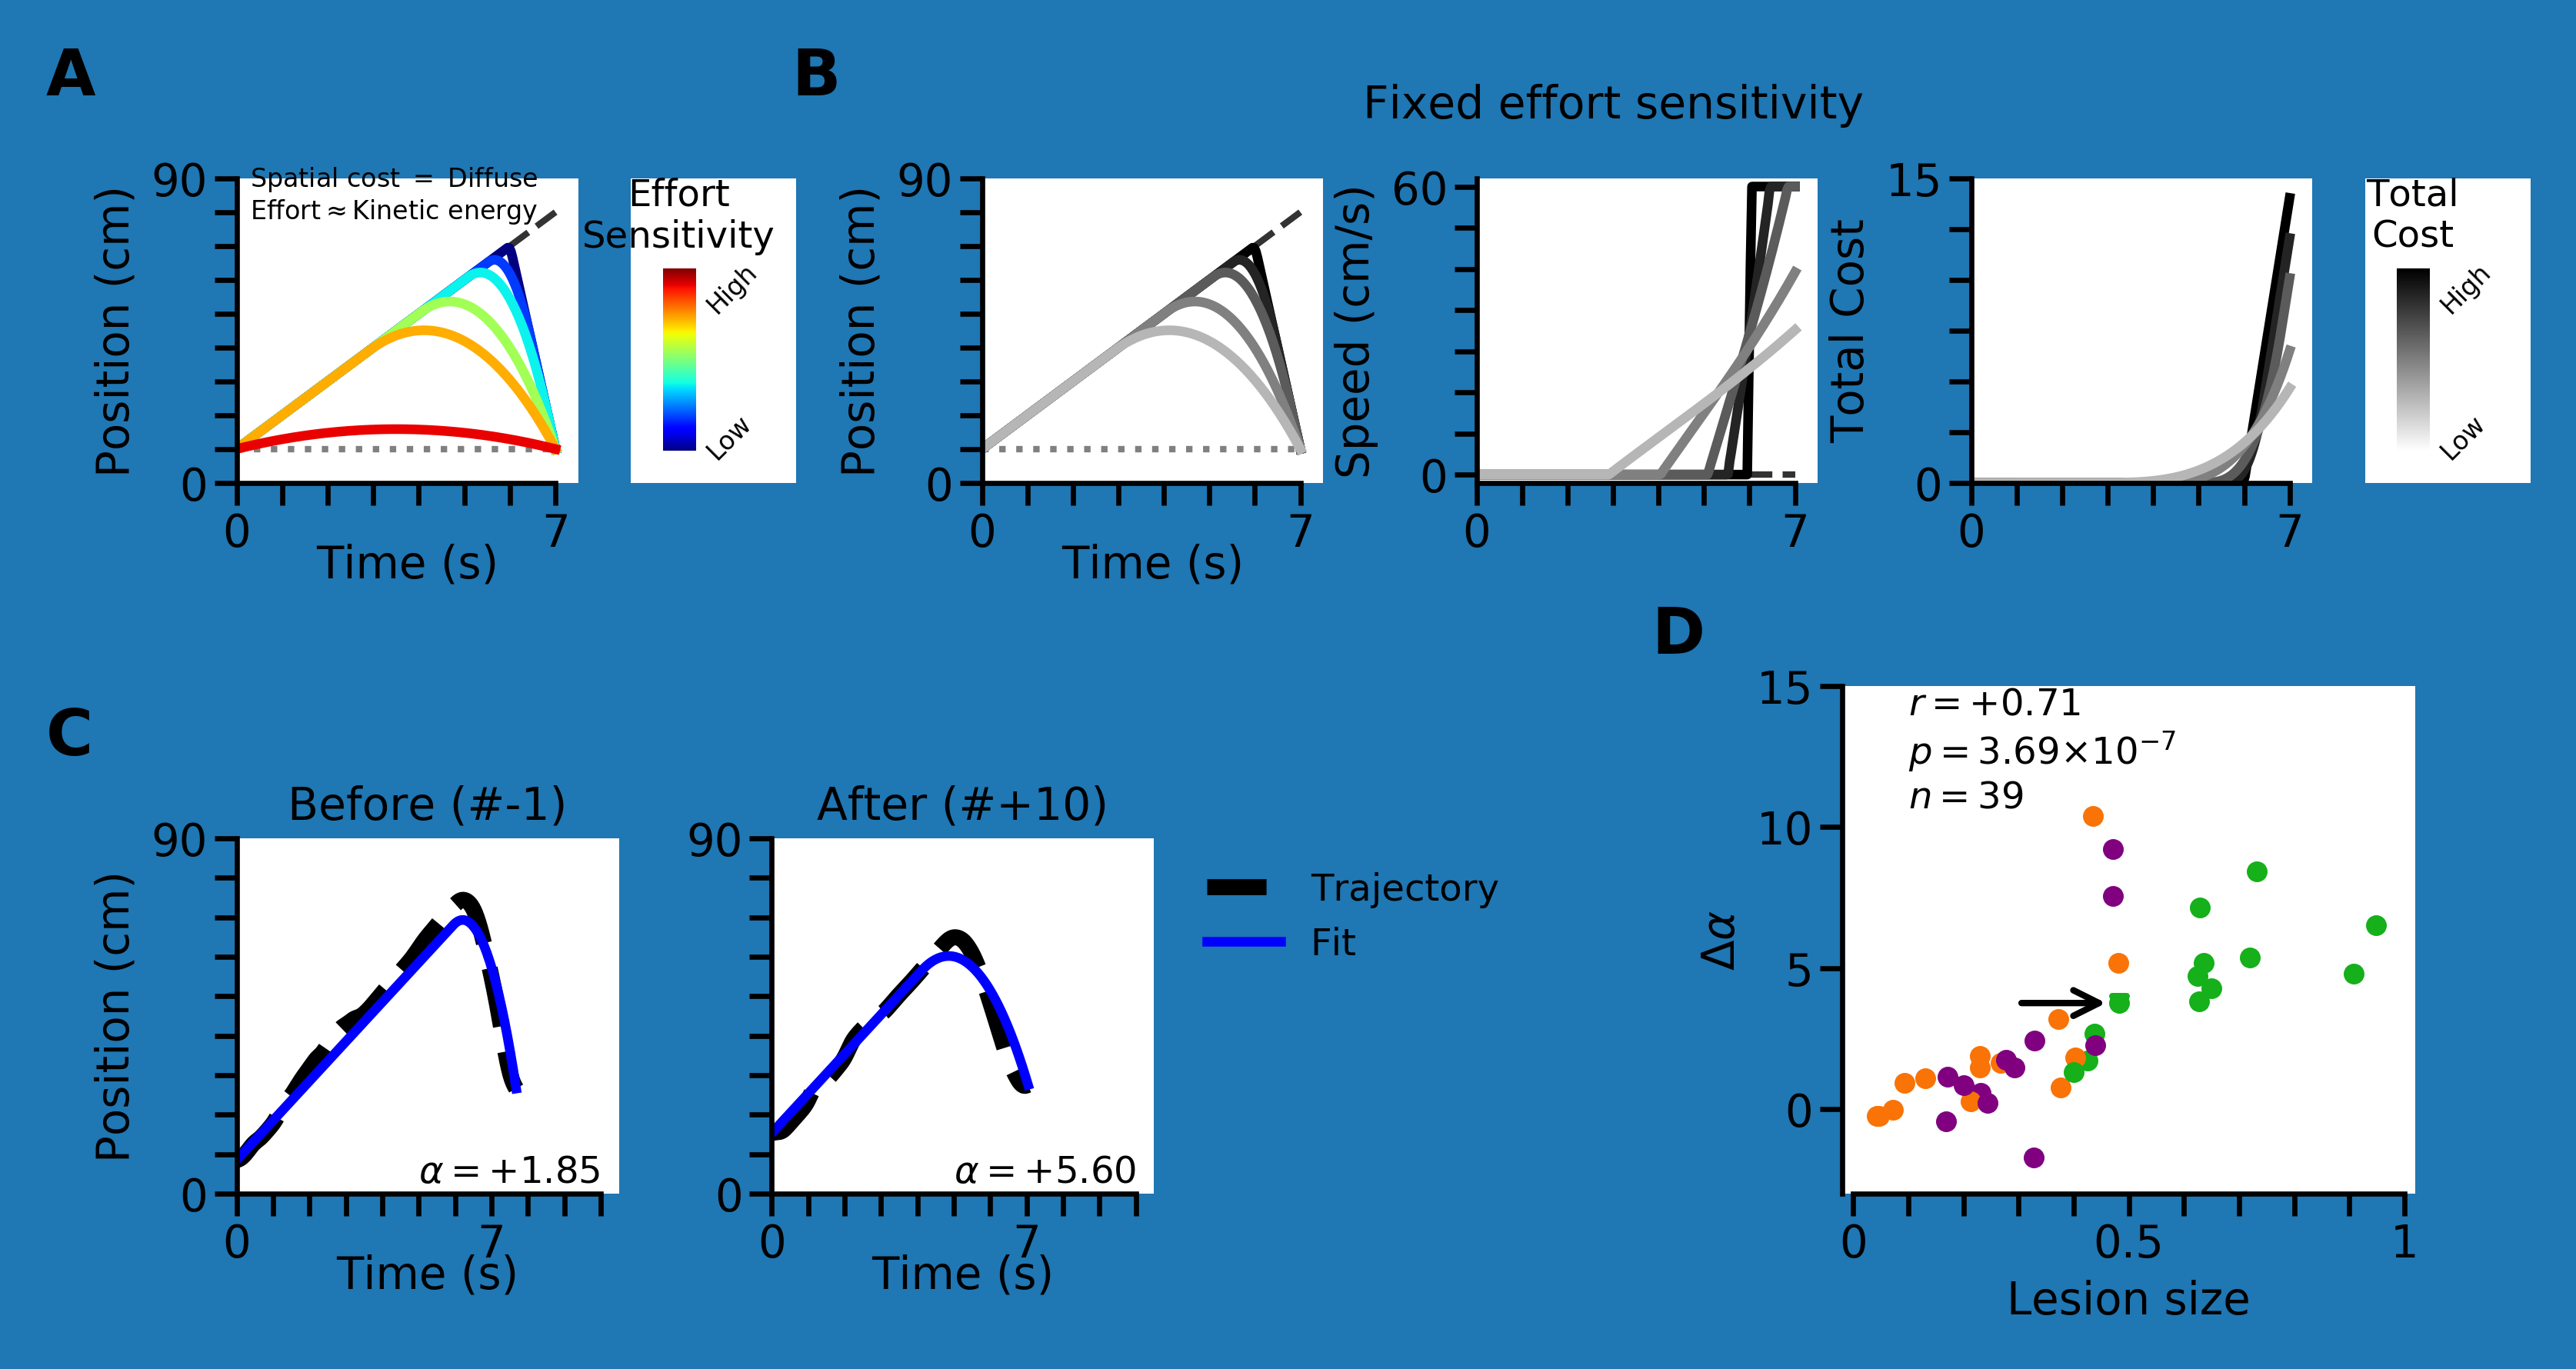

In [14]:
simulations_results_folder = 'PickleResults/Simulations'
steep_heaviside_effort_names_list = [simulations_results_folder + '/SteepHeavisideSpatialCostEffort.pickle']
diffuse_heaviside_effort_names_list = [simulations_results_folder + '/DiffuseHeavisideSpatialCostEffort.pickle']
steep_heaviside_mass_names_list = [simulations_results_folder + '/SteepHeavisideSpatialCostMass.pickle']
diffuse_heaviside_mass_names_list = [simulations_results_folder + '/DiffuseHeavisideSpatialCostMass.pickle']

# Load desired data and define relevant variables
file_to_open = steep_heaviside_effort_names_list[0]
with open(file_to_open, 'rb') as handle:
    results = pickle.load(handle)  
xk_vect_speed_heav_steep_effort = results['xk_vect_speed_heav']
xk_vect_force_heav_steep_effort = results['xk_vect_force_heav']

file_to_open = diffuse_heaviside_effort_names_list[0]
with open(file_to_open, 'rb') as handle:
    results = pickle.load(handle)  
xk_vect_speed_heav_diffuse_effort = results['xk_vect_speed_heav']
xk_vect_force_heav_diffuse_effort = results['xk_vect_force_heav']


file_to_open = steep_heaviside_mass_names_list[0]
with open(file_to_open, 'rb') as handle:
    results = pickle.load(handle)  
xk_vect_speed_heav_steep_mass = results['xk_vect_speed_heav']
xk_vect_force_heav_steep_mass = results['xk_vect_force_heav']

file_to_open = diffuse_heaviside_mass_names_list[0]
with open(file_to_open, 'rb') as handle:
    results = pickle.load(handle)  
xk_vect_speed_heav_diffuse_mass = results['xk_vect_speed_heav']
xk_vect_force_heav_diffuse_mass = results['xk_vect_force_heav']

tk = results['tk_vect_speed_heav'][:,0] # this is independent on the model

In [15]:
aux_a = [.1,1,2,5,10,100] 
NTRAJECTORIES = len(aux_a) # I get rid of the alpha=2000
cmap = matplotlib.cm.get_cmap('jet', 2*NTRAJECTORIES)

##############################################################
plt.close('all')
set_rc_params({'axes.labelsize':'x-small'})

nrows = 1
ncols = 4

figsize=(3.6,1.8)
linewidth = 1.5
fig=plt.figure(figsize=figsize,dpi=600)
fig.set_facecolor(None)
axes = []
##################################################################################################
gs = fig.add_gridspec(nrows=nrows, ncols=ncols, left=0, bottom=0.62, right=.88, top=1.,wspace=0.15,hspace=0.3)
##################################################################################################
# FIRST PANEL
ax=fig.add_subplot(gs[0])
axes.append(ax)

for it in range(NTRAJECTORIES):
    ax.plot(tk,xk_vect_speed_heav_steep_effort[:,it],linewidth=linewidth,alpha=1.0,c=cmap(2*it))
    
ax.text(0.3,.78,'Spatial cost $=$ Localized \nEffort' + r'$\approx$' + 'Kinetic energy',fontsize=4)
#################################################
# SECOND PANEL    
ax=fig.add_subplot(gs[1])
axes.append(ax)

for it in range(NTRAJECTORIES):
    ax.plot(tk,xk_vect_speed_heav_diffuse_effort[:,it],linewidth=linewidth,alpha=1.0,c=cmap(2*it))
    
ax.text(0.3,.78,'Spatial cost $=$ Diffuse \nEffort' + r'$\approx$' + 'Kinetic energy',fontsize=4)
#################################################
# THIRD PANEL
ax=fig.add_subplot(gs[2])
axes.append(ax)
  
for it in range(NTRAJECTORIES):
    ax.plot(tk,xk_vect_force_heav_steep_effort[:,it],linewidth=linewidth,alpha=1.0,c=cmap(2*it))
       
ax.text(0.3,.78,'Spatial cost $=$ Localized \nEffort' + r'$\approx$' + 'Force$^2$',fontsize=4)
ax.text(-5.0,1.05,'Fixed rat\'s weight', fontsize=7)
#################################################
# FOURTH PANEL
ax=fig.add_subplot(gs[3])
axes.append(ax)

for it in range(NTRAJECTORIES):
    ax.plot(tk,xk_vect_force_heav_diffuse_effort[:,it],linewidth=linewidth,alpha=1.0,c=cmap(2*it))

ax.text(0.3,.78,'Spatial cost $=$ Diffuse \nEffort' + r'$\approx$' + 'Force$^2$',fontsize=4)
#############################################
# COLORMAP
gsc = fig.add_gridspec(nrows=1,ncols=1,left=.92,bottom=0.62,top=1,right=1)
axc = fig.add_subplot(gsc[0])
axc.xaxis.set_visible(False)
axc.spines['left'].set_visible(False)
axc.spines['bottom'].set_visible(False)
axc.spines['top'].set_visible(False)
axc.spines['right'].set_visible(False)
axc.tick_params(color=(0, 0, 0, 0),labelcolor=(0, 0, 0, 0),zorder=-10)

c = np.arange(1, 50*NTRAJECTORIES + 1)
cmap_ = matplotlib.cm.get_cmap('jet', 50*NTRAJECTORIES)
dummie_cax = axc.scatter(c, c, c=c, cmap=cmap_)
# Clear axis
axc.cla()

cbaxes = inset_axes(axc, width="20%", height="60%",loc=3) 
shift = 50
cb=fig.colorbar(dummie_cax,cax=cbaxes,ticks=[1+shift,50*NTRAJECTORIES],aspect=10)
cb.outline.set_edgecolor(None)
cb.set_label('Effort\nSensitivity', labelpad=-13,y=1.5, rotation=0,fontsize='xx-small')

cb.ax.set_yticklabels(['Low', 'High'],rotation=45,fontsize=4)
cb.ax.yaxis.set_tick_params(size=0)
#############################################

##################################################################################################
gs = fig.add_gridspec(nrows=nrows, ncols=ncols, left=0, bottom=0, right=.88, top=.38,wspace=0.15,hspace=0.3)
##################################################################################################
# FIRST PANEL
ax=fig.add_subplot(gs[0])
axes.append(ax)

for it in range(NTRAJECTORIES):
    ax.plot(tk,xk_vect_speed_heav_steep_mass[:,it],linewidth=linewidth,alpha=1.0,c=cmap(2*it))

ax.set_xlabel('Time (s)',labelpad=-5)
#################################################
# SECOND PANEL    
ax=fig.add_subplot(gs[1])
axes.append(ax)

for it in range(NTRAJECTORIES):
    ax.plot(tk,xk_vect_speed_heav_diffuse_mass[:,it],linewidth=linewidth,alpha=1.0,c=cmap(2*it))
#################################################
# THIRD PANEL
ax=fig.add_subplot(gs[2])
axes.append(ax)
  
for it in range(NTRAJECTORIES):
    ax.plot(tk,xk_vect_force_heav_steep_mass[:,it],linewidth=linewidth,alpha=1.0,c=cmap(2*it))
       
ax.text(-6.5,1.05,'Fixed effort sensitivity',fontsize=7)
#################################################
# FOURTH PANEL
ax=fig.add_subplot(gs[3])
axes.append(ax)

for it in range(NTRAJECTORIES):
    ax.plot(tk,xk_vect_force_heav_diffuse_mass[:,it],linewidth=linewidth,alpha=1.0,c=cmap(2*it))
#############################################
# COLORMAP
gsc = fig.add_gridspec(nrows=1,ncols=1,left=.92,bottom=0,top=.38,right=1)
axc = fig.add_subplot(gsc[0])
axc.xaxis.set_visible(False)
axc.spines['left'].set_visible(False)
axc.spines['bottom'].set_visible(False)
axc.spines['top'].set_visible(False)
axc.spines['right'].set_visible(False)
axc.tick_params(color=(0, 0, 0, 0),labelcolor=(0, 0, 0, 0),zorder=-10)

c = np.arange(1, 50*NTRAJECTORIES + 1)
cmap_ = matplotlib.cm.get_cmap('jet', 50*NTRAJECTORIES)
dummie_cax = axc.scatter(c, c, c=c, cmap=cmap_)
# Clear axis
axc.cla()

cbaxes = inset_axes(axc, width="20%", height="60%",loc=3) 
shift = 50
cb=fig.colorbar(dummie_cax,cax=cbaxes,ticks=[1+shift,50*NTRAJECTORIES],aspect=10)
cb.outline.set_edgecolor(None)
cb.set_label('Rat\'s\nWeight', labelpad=-13,y=1.5, rotation=0,fontsize='xx-small')
cb.ax.set_yticklabels(['Low', 'High'],rotation=45,fontsize=4)
cb.ax.yaxis.set_tick_params(size=0)
#################################################

###############################################################################
for ind_ax,ax in enumerate(axes):
    
    ax.plot(tk,xk_vect_speed_heav[0,0]+[0.1*t for t in tk],'--',color='Black',alpha=.8,zorder=-1,linewidth=1)
    ax.plot(tk,[0.1 for t in tk],':',color='Gray',zorder=-1,linewidth=1)
    
    if ind_ax%4==0:
        ax.set_ylabel('Position (cm)')    
        ax.set_yticklabels(['0'] + ['' for i in range(8)] + ['90'])
    elif ind_ax==4:
        ax.set_xlabel('Time (s)',labelpad=-5)
    else:
        ax.set_yticks([0.1*i for i in range(10)])
        ax.set_yticklabels(['' for i in range(10)])
    
    ax.set_yticks([0.1*i for i in range(10)])
    ax.set_xticks([i for i in range(8)])
    
    if ind_ax>3:
        ax.set_xticklabels(['0'] + ['' for i in range(6)] + ['7'])
    else:
        ax.set_xticklabels(['' for i in range(8)])
        
    ax.set_xlim(0,7.5)
    ax.set_ylim(0,0.9)
    ax.spines['bottom'].set_bounds(0,7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
###############################################################################
add_panel_caption(axes=(axes[0],axes[4],),offsetX=(.083,.083,),offsetY=(.1,.1,))
###############################################################################
    
fig.savefig(figures_folder + 'SuppFigure_VariableEffortSensitivityMass.pdf',format='pdf', bbox_inches='tight')